/var/folders/ln/kls56lq93mq4z_459sxk1vbh0000gn/T/ipykernel_84273/3223201690.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(TICKER)
[*********************100%***********************]  1 of 1 completed


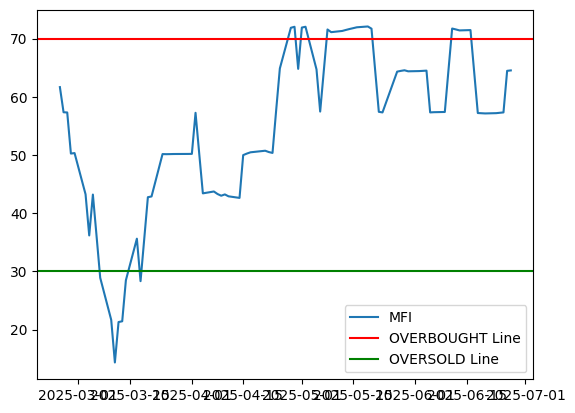

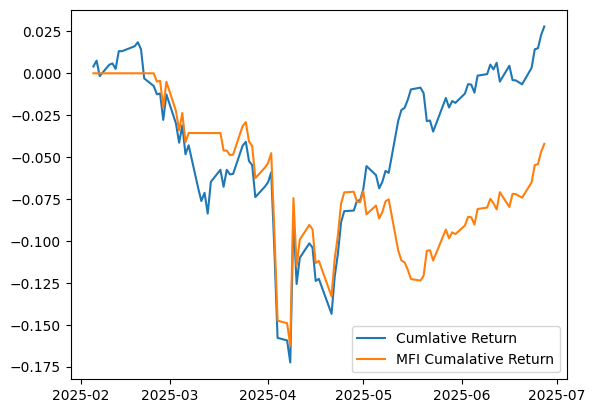

In [ ]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

TICKER = "SPY"
MFI_LENGTH = 14
LOOKBACK = 1000
OVERBOUGHT = 70
OVERSOLD = 30


def get_data():
    df = yf.download(TICKER)
    df.columns = df.columns.get_level_values(0)
    return df.iloc[-LOOKBACK:, :]

def add_mfi(df):

    df["Average Price"] = df["High"] + df["Low"] + df["Close"] / 3
    df["Money Flow"] = df["Volume"] * df["Average Price"]

    df["Pos Flow"] = df["Average Price"].where(df["Average Price"].diff() > 0, 0)
    df["Neg Flow"] = df["Average Price"].where(df["Average Price"].diff() < 0, 0)

    mfr = (
        df["Pos Flow"].rolling(MFI_LENGTH).sum()
        / df["Neg Flow"].rolling(MFI_LENGTH).sum()
    )

    df["MFI"] = 100 - (100 / (1 + mfr))

    plt.plot(df["MFI"])
    plt.axhline(OVERBOUGHT, color="red")
    plt.axhline(OVERSOLD, color="green")
    plt.legend(["MFI", "OVERBOUGHT Line", "OVERSOLD Line"])
    return df


def add_strategy(df):
    df["Strategy"] = np.where(
        df["MFI"] > OVERBOUGHT, -1, np.where(df["MFI"] > OVERSOLD, 1,0)
    )
    df["Strategy"] = df["Strategy"].shift(1)
    return df


def test_strategy(df):
    df["Cumalative Return"] = np.cumprod(1 + df["Close"].pct_change()) - 1
    df["MFI Cumalative Return"] = (
        np.cumprod(1 + df["Close"].pct_change() * df["Strategy"]) - 1
    )

    plt.figure()
    plt.plot(df["Cumalative Return"])
    plt.plot(df["MFI Cumalative Return"])
    plt.legend([f"Cumlative Return", f"MFI Cumalative Return"])
    return df


def main():
    df = get_data()
    df = add_mfi(df)
    df = add_strategy(df)
    df = test_strategy(df)


main()